In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

import optuna
from optuna.samplers import CmaEsSampler, RandomSampler

import copy

# For reproducability
def set_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True)

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")


set_seed(50)

c:\Users\Abhay.Sharma\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
'''{ from google.colab import files
uploaded = files.upload()

! pip install tensorboard
! pip install optuna
! pip install optuna-integration[tensorboard]
 }'''

# ! pip install shap

'{ from google.colab import files\nuploaded = files.upload()\n\n! pip install tensorboard\n! pip install optuna\n! pip install optuna-integration[tensorboard]\n }'

#  Exploratory Data analysis

In [ ]:
# Converting the data into pandas dataframe
complete_data=pd.read_csv('Australian_Vehicle_Prices.csv')


print(f'Shape of data is {complete_data.shape}')

categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()

print(f'Categorical columns \n {categorical_cols}')
print(f'Numerical columns \n {numerical_cols}')

Shape of data is (16734, 19)
Categorical columns 
 ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'Kilometres', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats', 'Price']
Numerical columns 
 ['Year']


In [ ]:
# First few rows of the data
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990


In [ ]:
# Missing cells
complete_data.isnull().sum().sort_values(ascending=False)

Seats                1705
Doors                1604
Location              450
BodyType              282
Car/Suv                28
Price                   3
Brand                   1
Model                   1
Year                    1
UsedOrNew               1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
CylindersinEngine       1
Kilometres              1
ColourExtInt            1
dtype: int64

# Visual CSV Data observations   
Some common observations-    
Some columns like kilometers, transmission, fuel are shown to having only few missing values but many values are fillled with symbols '-'.   
All vehicles with columns 'New available to order' have '-' in price instead of 0  
Some prices are filled with 'POA'



# Data cleaning & refinement

In [ ]:
# Fill NEW Available to order column with 0 kms
complete_data.loc[complete_data['Car/Suv'] == 'NEW Available to order', 'Kilometres'] = 0

# Converting into numeric columns
cols_to_convert = ['Kilometres','Price']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')


# new list of categoric and numeric cols
categorical_cols = complete_data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = complete_data.select_dtypes(include=['number']).columns.tolist()
print('Categorical cols-',categorical_cols)
print('Numerical cols-', numerical_cols)

# Missing cells
print('\nempty Cells-','\n',complete_data.isnull().sum().sort_values(ascending=False))

Categorical cols- ['Brand', 'Model', 'Car/Suv', 'Title', 'UsedOrNew', 'Transmission', 'Engine', 'DriveType', 'FuelType', 'FuelConsumption', 'ColourExtInt', 'Location', 'CylindersinEngine', 'BodyType', 'Doors', 'Seats']
Numerical cols- ['Year', 'Kilometres', 'Price']

empty Cells- 
 Seats                1705
Doors                1604
Location              450
BodyType              282
Kilometres            156
Price                  53
Car/Suv                28
Model                   1
Year                    1
Brand                   1
Title                   1
FuelConsumption         1
FuelType                1
DriveType               1
Engine                  1
Transmission            1
UsedOrNew               1
CylindersinEngine       1
ColourExtInt            1
dtype: int64


In [ ]:
complete_data.dropna(subset=['Price'], inplace=True)
complete_data.isnull().sum().sort_values(ascending=False)
complete_data_original_columns=complete_data.copy()

print('Mean price-', complete_data['Price'].mean())
print('Max price-', complete_data['Price'].max())
print('Min price-', complete_data['Price'].min())


Mean price- 37303.33463221629
Max price- 1500000.0
Min price- 88.0


In [ ]:
# Outrliers check

from scipy import stats
complete_data = complete_data[complete_data['Price'] > 500]
z_scores = np.abs(stats.zscore(complete_data['Price']))
outliers = complete_data[z_scores > 10]
print(outliers)

               Brand    Year        Model                    Car/Suv  \
3036     Lamborghini  2019.0         Urus                        SUV   
3357         McLaren  2019.0         720S                Convertible   
3837   Mercedes-Benz  2023.0          G63             USED Dealer ad   
4046   Mercedes-Benz  2023.0          G63       Sydney Luxury Motors   
5271         Ferrari  2019.0         GTC4                      Coupe   
5502         Bentley  2020.0  Continental  Lorbek Luxury Cars Sydney   
10358    Lamborghini  2012.0    Aventador                      Coupe   
14924        Bentley  2023.0  Continental     NEW Available to order   
14932        Bentley  2023.0  Continental     NEW Available to order   
14943        Bentley  2023.0  Continental     NEW Available to order   
15053        McLaren  2023.0        600LT     NEW Available to order   
15079          Aston  2023.0       Martin     NEW Available to order   
15098        McLaren  2023.0         720S     NEW Available to o

In [ ]:
#  Converting some columns form large categorical sets to nummeric

complete_data['Engine_capacity']=complete_data['Engine'].str.split(',').str[1]
complete_data['Engine_capacity'] = complete_data['Engine_capacity'].str.replace(' L', '', regex=False)

complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()
complete_data['FuelConsumption'] = complete_data['FuelConsumption'].str.replace(' L / 100 km', '', regex=False).str.strip()

complete_data[['City', 'State']] = complete_data['Location'].str.split(',', expand=True)

complete_data['CylindersinEngine'] =complete_data['CylindersinEngine'].str.split().str[0]
complete_data['Doors'] =complete_data['Doors'].str.split().str[0]
complete_data['Seats'] =complete_data['Seats'].str.split().str[0]

cols_to_convert = ['Engine_capacity','FuelConsumption','Doors','Seats']
complete_data[cols_to_convert] = complete_data[cols_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
# unique values in each column
print('Unique values in each column','\n', complete_data.nunique())

Unique values in each column 
 Brand                   76
Year                    45
Model                  781
Car/Suv                615
Title                 8784
UsedOrNew                3
Transmission             3
Engine                 106
DriveType                5
FuelType                 9
FuelConsumption        156
Kilometres           14255
ColourExtInt           831
Location               618
CylindersinEngine       10
BodyType                10
Doors                    9
Seats                   13
Price                 3792
Engine_capacity         65
City                   606
State                    9
dtype: int64


In [ ]:
complete_data['Price'] = complete_data[['Price']].astype(int)
complete_data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,...,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price,Engine_capacity,City,State
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,...,White / Black,"Caringbah, NSW",4,SUV,4.0,7.0,51990,2.2,Caringbah,NSW
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,...,Black / Black,"Brookvale, NSW",4,Hatchback,5.0,5.0,19990,1.5,Brookvale,NSW
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,...,Grey / White,"Sylvania, NSW",4,Coupe,2.0,4.0,108988,2.0,Sylvania,NSW
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,...,White / Brown,"Mount Druitt, NSW",8,Coupe,2.0,4.0,32990,5.5,Mount Druitt,NSW
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,...,Grey / Black,"Castle Hill, NSW",4,SUV,4.0,5.0,34990,1.3,Castle Hill,NSW


In [ ]:
complete_data.isnull().sum().sort_values(ascending=False)

Engine_capacity      1766
Seats                1688
FuelConsumption      1681
Doors                1587
Location              449
City                  449
State                 449
BodyType              279
Kilometres            139
Car/Suv                26
Brand                   0
Title                   0
Model                   0
Year                    0
UsedOrNew               0
ColourExtInt            0
DriveType               0
FuelType                0
Transmission            0
Engine                  0
CylindersinEngine       0
Price                   0
dtype: int64

# Seperating training and test data

In [ ]:
# Extract last 1000 rows into a new DataFrame
Test_data = complete_data.tail(1000).copy()
y_actual_test=Test_data['Price'].astype(int)

# Remove last 1000 rows from the original DataFrame
Training_data= complete_data.iloc[:-1000]
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']

# Mutual information chart for feature importance

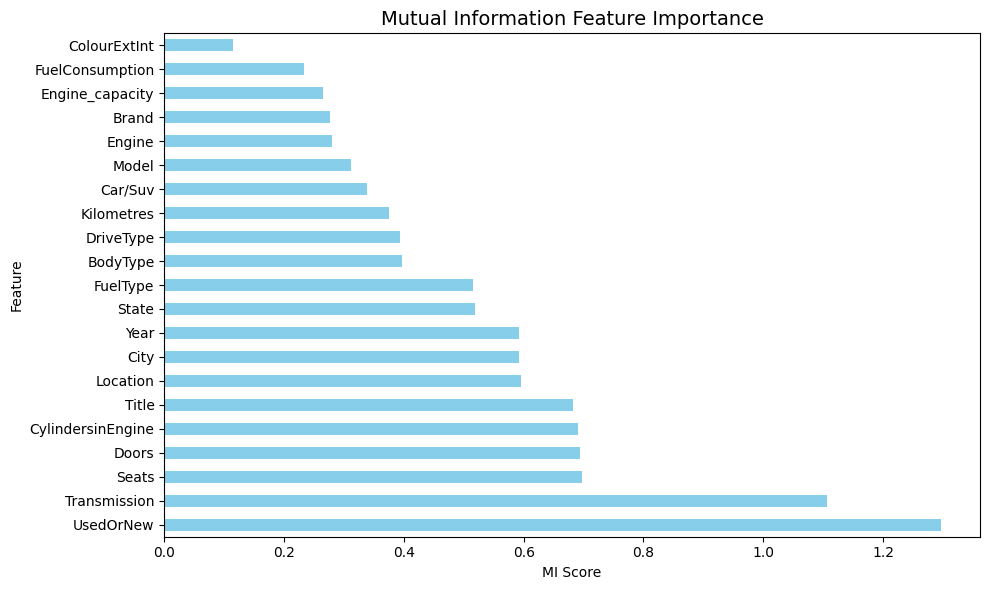

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# Calculating mi scores
for col in X.select_dtypes(include='object').columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X.fillna(0, inplace=True)

mi = mutual_info_classif(X, y,random_state=50)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# Plotting mi scores
plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh', color='skyblue')
plt.title("Mutual Information Feature Importance", fontsize=14)
plt.xlabel("MI Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Return to original x and y
X=Training_data.drop('Price',axis=1)
y=Training_data['Price']


# Data splitting into training and validation data

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=50)

categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() <= 76 and  (X_train_full[cname].dtype == "object" or X_train_full[cname].dtype.name == "category")]
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_cols),('cat', categorical_transformer, categorical_cols)])

X_train_pre = preprocessor.fit_transform(X_train_full)
X_valid_pre = preprocessor.transform(X_valid_full)
X_test_pre = preprocessor.transform(Test_data)


In [ ]:
num_features = numerical_cols

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)

feature_names = list(num_features) + list(cat_features)
print(feature_names)

['Year', 'FuelConsumption', 'Kilometres', 'Doors', 'Seats', 'Engine_capacity', 'Brand_Abarth', 'Brand_Alfa', 'Brand_Aston', 'Brand_Audi', 'Brand_BMW', 'Brand_BYD', 'Brand_Bentley', 'Brand_Caterham', 'Brand_Chery', 'Brand_Chevrolet', 'Brand_Chrysler', 'Brand_Citroen', 'Brand_Cupra', 'Brand_Daihatsu', 'Brand_Dodge', 'Brand_FPV', 'Brand_Ferrari', 'Brand_Fiat', 'Brand_Ford', 'Brand_Foton', 'Brand_GWM', 'Brand_Geely', 'Brand_Genesis', 'Brand_Great', 'Brand_HSV', 'Brand_Haval', 'Brand_Hino', 'Brand_Holden', 'Brand_Honda', 'Brand_Hummer', 'Brand_Hyundai', 'Brand_Ineos', 'Brand_Infiniti', 'Brand_International', 'Brand_Isuzu', 'Brand_Iveco', 'Brand_Jaguar', 'Brand_Jeep', 'Brand_Kia', 'Brand_LDV', 'Brand_Lamborghini', 'Brand_Land', 'Brand_Lexus', 'Brand_Lotus', 'Brand_MG', 'Brand_Mahindra', 'Brand_Maserati', 'Brand_Mazda', 'Brand_McLaren', 'Brand_Mercedes-Benz', 'Brand_Mini', 'Brand_Mitsubishi', 'Brand_Nissan', 'Brand_Opel', 'Brand_Peugeot', 'Brand_Polestar', 'Brand_Porsche', 'Brand_Proton', 'Br

# Pytorch model

In [ ]:
total_epochs=400

X_train_tensor=torch.tensor(X_train_pre.todense(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
if y_train_tensor.dim() == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
dataset=TensorDataset(X_train_tensor,y_train_tensor)

X_valid_tensor=torch.tensor(X_valid_pre.todense(), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
if y_valid_tensor.dim() == 1:
    y_valid_tensor = y_valid_tensor.unsqueeze(1)

X_test_tensor=torch.tensor(X_test_pre.todense(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_actual_test.values, dtype=torch.float32)
if y_test_tensor.dim() == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)


class Regressor(nn.Module):
    torch.manual_seed(50)
    def __init__(self, input_dim, units,num_layers):
        super().__init__()
        layers=[]
        in_dim=input_dim


        for i in range(num_layers):
            out_dim=units*2**(num_layers-(i+1))
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_dim=out_dim
        layers.append(nn.Linear(in_dim,1))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)

# Hyperparameter tuning

In [ ]:
def objective(trial):
    set_seed(50)

    # Early stopping
    patience=20
    min_delta=10
    best_valid_loss=float('inf')
    epochs_no_improve=0
    best_model_state = None

    num_layers=trial.suggest_int('num_layers',2,4)
    units = trial.suggest_int('units', 110, 200)
    batch_size = trial.suggest_int('batch_size', 500, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.01)


    model = Regressor(input_dim=X_train_pre.shape[1], units=units,num_layers=num_layers)
    criterion=nn.L1Loss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)


    log_dir = f"runs_{timestamp}/fit/Trial_{trial.number}"
    writer=SummaryWriter(log_dir)


    loader=DataLoader(dataset, batch_size=batch_size, shuffle=True,  worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50),num_workers=0)

    #Train the model
    for epoch in range(total_epochs):
        model.train()
        train_loss = 0
        total_samples = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred=model(X_batch)
            loss=criterion(y_pred,y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            total_samples += X_batch.size(0)
        train_loss = train_loss / total_samples

        model.eval()
        with torch.inference_mode():
            y_pred_valid = model(X_valid_tensor)
            valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))
            writer.add_scalars('Loss', {'Train': train_loss,'Valid': valid_loss}, epoch)

        print(f'{epoch+1}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

        if (best_valid_loss - valid_loss) > min_delta:
            # Improvement
            epochs_no_improve = 0
            best_valid_loss = valid_loss
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
        else:
            # No improvement
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {best_epoch} with val_loss {best_valid_loss:.4f}")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_valid_loss:.4f} at epoch {best_epoch} \n")

    writer.add_scalar('Parameters/Units', units, trial.number)
    writer.add_scalar('Parameters/Batch_size', batch_size, trial.number)
    writer.add_scalar('Parameters/Learning_rate', learning_rate, trial.number)
    writer.add_scalar('Parameters/Num_layers', num_layers, trial.number)
    writer.add_scalar('Loss/Train_loss', train_loss, trial.number)
    writer.add_scalar('Loss/Valid_loss', valid_loss, trial.number)


    writer.close()

    return best_valid_loss


In [ ]:
set_seed(50)

study = optuna.create_study(direction="minimize",study_name="Hyperparametr optimization with pytorch",sampler=optuna.samplers.TPESampler(seed=50))
study.optimize(objective, n_trials=15)

[I 2025-08-01 13:22:29,942] A new study created in memory with name: Hyperparametr optimization with pytorch


1/400 Train loss-36944.10002291932 Valid loss-37805.25
2/400 Train loss-36935.773778798626 Valid loss-37790.71484375
3/400 Train loss-36922.93431558414 Valid loss-37774.8203125
4/400 Train loss-36904.90861822634 Valid loss-37752.6875
5/400 Train loss-36881.43276728416 Valid loss-37726.4140625
6/400 Train loss-36851.66033966687 Valid loss-37696.453125
7/400 Train loss-36815.366193498885 Valid loss-37650.81640625
8/400 Train loss-36769.89962550572 Valid loss-37601.18359375
9/400 Train loss-36716.78850975815 Valid loss-37532.39453125
10/400 Train loss-36657.71426920988 Valid loss-37475.23046875
11/400 Train loss-36590.71160639549 Valid loss-37402.88671875
12/400 Train loss-36516.18725430236 Valid loss-37330.8046875
13/400 Train loss-36431.314335102936 Valid loss-37260.46484375
14/400 Train loss-36333.902218877054 Valid loss-37133.48828125
15/400 Train loss-36228.70801061513 Valid loss-37022.39453125
16/400 Train loss-36116.95764938666 Valid loss-36923.66015625
17/400 Train loss-36000.6918

[I 2025-08-01 13:25:14,645] Trial 0 finished with value: 5552.251953125 and parameters: {'num_layers': 3, 'units': 130, 'batch_size': 627, 'learning_rate': 0.004566969187504993}. Best is trial 0 with value: 5552.251953125.


272/400 Train loss-5310.085335906671 Valid loss-5810.16259765625
Early stopping at epoch 272
Best validation loss: 5552.2520 at epoch 251 

1/400 Train loss-36940.599479831 Valid loss-37795.578125
2/400 Train loss-36918.603495695155 Valid loss-37761.54296875
3/400 Train loss-36882.58541932398 Valid loss-37716.359375
4/400 Train loss-36829.03304368623 Valid loss-37653.33203125
5/400 Train loss-36755.857860331635 Valid loss-37566.12890625
6/400 Train loss-36661.9658203125 Valid loss-37456.88671875
7/400 Train loss-36544.59498565051 Valid loss-37323.9765625
8/400 Train loss-36393.2373046875 Valid loss-37160.6953125
9/400 Train loss-36210.21131616709 Valid loss-36953.48046875
10/400 Train loss-36007.551777742345 Valid loss-36731.6640625
11/400 Train loss-35781.4505341199 Valid loss-36501.89453125
12/400 Train loss-35530.348612882655 Valid loss-36241.82421875
13/400 Train loss-35255.508121412626 Valid loss-35950.36328125
14/400 Train loss-34956.84560347576 Valid loss-35662.765625
15/400 Tra

[I 2025-08-01 13:27:29,561] Trial 1 finished with value: 5355.6142578125 and parameters: {'num_layers': 3, 'units': 200, 'batch_size': 704, 'learning_rate': 0.007947045953557424}. Best is trial 1 with value: 5355.6142578125.


146/400 Train loss-4507.741152393574 Valid loss-5416.79931640625
Early stopping at epoch 146
Best validation loss: 5355.6143 at epoch 125 

1/400 Train loss-36944.85295416384 Valid loss-37806.3515625
2/400 Train loss-36938.13200440699 Valid loss-37795.5703125
3/400 Train loss-36928.38470863809 Valid loss-37785.0703125
4/400 Train loss-36915.035039784954 Valid loss-37769.3359375
5/400 Train loss-36897.65987878916 Valid loss-37749.78515625
6/400 Train loss-36876.06056587063 Valid loss-37724.19140625
7/400 Train loss-36849.995296556124 Valid loss-37695.703125
8/400 Train loss-36819.2170637481 Valid loss-37660.203125
9/400 Train loss-36784.05309217803 Valid loss-37624.51171875
10/400 Train loss-36743.97023944466 Valid loss-37578.265625
11/400 Train loss-36698.711032478175 Valid loss-37532.58203125
12/400 Train loss-36648.197851375655 Valid loss-37480.61328125
13/400 Train loss-36594.069213555784 Valid loss-37420.99609375
14/400 Train loss-36534.75424100915 Valid loss-37363.97265625
15/400 

[I 2025-08-01 15:19:45,489] Trial 2 finished with value: 5374.8359375 and parameters: {'num_layers': 4, 'units': 138, 'batch_size': 673, 'learning_rate': 0.004165883357469062}. Best is trial 1 with value: 5355.6142578125.


233/400 Train loss-4500.660479195264 Valid loss-5475.39013671875
Early stopping at epoch 233
Best validation loss: 5374.8359 at epoch 212 

1/400 Train loss-36943.72526550293 Valid loss-37806.828125
2/400 Train loss-36933.68264023139 Valid loss-37792.39453125
3/400 Train loss-36918.818443454045 Valid loss-37769.15234375
4/400 Train loss-36898.546866903496 Valid loss-37743.09765625
5/400 Train loss-36871.871442833726 Valid loss-37711.65234375
6/400 Train loss-36838.54502993214 Valid loss-37673.67578125
7/400 Train loss-36798.196805992906 Valid loss-37628.40625
8/400 Train loss-36750.03958565848 Valid loss-37572.00390625
9/400 Train loss-36693.84655652727 Valid loss-37508.9140625
10/400 Train loss-36629.38105026557 Valid loss-37438.06640625
11/400 Train loss-36556.1440635214 Valid loss-37354.60546875
12/400 Train loss-36473.41290158642 Valid loss-37268.93359375
13/400 Train loss-36382.056236111384 Valid loss-37177.1640625
14/400 Train loss-36279.69749575245 Valid loss-37075.7421875
15/40

[I 2025-08-01 15:21:16,320] Trial 3 finished with value: 5434.24853515625 and parameters: {'num_layers': 2, 'units': 198, 'batch_size': 955, 'learning_rate': 0.006039613933499126}. Best is trial 1 with value: 5355.6142578125.


233/400 Train loss-4686.768192174483 Valid loss-5516.24853515625
Early stopping at epoch 233
Best validation loss: 5434.2485 at epoch 212 

1/400 Train loss-36944.51015098728 Valid loss-37808.54296875
2/400 Train loss-36937.264748709546 Valid loss-37798.64453125
3/400 Train loss-36926.819697788786 Valid loss-37781.6640625
4/400 Train loss-36912.71309770857 Valid loss-37763.5625
5/400 Train loss-36894.723975668145 Valid loss-37743.296875
6/400 Train loss-36872.4419549436 Valid loss-37718.12890625
7/400 Train loss-36845.93913113341 Valid loss-37689.21875
8/400 Train loss-36814.73854376345 Valid loss-37652.84765625
9/400 Train loss-36778.74771803252 Valid loss-37614.64453125
10/400 Train loss-36737.580302647184 Valid loss-37568.83984375
11/400 Train loss-36691.07549083476 Valid loss-37519.28125
12/400 Train loss-36639.96086681132 Valid loss-37463.5625
13/400 Train loss-36582.16571854572 Valid loss-37402.4375
14/400 Train loss-36519.11680634168 Valid loss-37337.21484375
15/400 Train loss-3

[I 2025-08-01 15:23:07,878] Trial 4 finished with value: 5338.15869140625 and parameters: {'num_layers': 2, 'units': 190, 'batch_size': 837, 'learning_rate': 0.004519787028747055}. Best is trial 4 with value: 5338.15869140625.


277/400 Train loss-4813.072782983585 Valid loss-5362.5791015625
Early stopping at epoch 277
Best validation loss: 5338.1587 at epoch 256 

1/400 Train loss-36944.30231958506 Valid loss-37806.40234375
2/400 Train loss-36936.056803800624 Valid loss-37793.36328125
3/400 Train loss-36923.93616345464 Valid loss-37775.7421875
4/400 Train loss-36907.479703942125 Valid loss-37755.3046875
5/400 Train loss-36885.90174149494 Valid loss-37729.70703125
6/400 Train loss-36858.6549184371 Valid loss-37700.0703125
7/400 Train loss-36825.53732984893 Valid loss-37661.15234375
8/400 Train loss-36786.37595974669 Valid loss-37619.23046875
9/400 Train loss-36740.93482504086 Valid loss-37568.96484375
10/400 Train loss-36688.32941919444 Valid loss-37512.828125
11/400 Train loss-36629.51846375757 Valid loss-37446.9609375
12/400 Train loss-36560.918784628106 Valid loss-37374.04296875
13/400 Train loss-36481.12566142179 Valid loss-37276.38671875
14/400 Train loss-36396.93523671676 Valid loss-37197.51953125
15/400

[I 2025-08-01 15:25:11,209] Trial 5 finished with value: 5988.45068359375 and parameters: {'num_layers': 3, 'units': 157, 'batch_size': 964, 'learning_rate': 0.00614235762135034}. Best is trial 4 with value: 5338.15869140625.


187/400 Train loss-5734.298075306172 Valid loss-6068.7626953125
Early stopping at epoch 187
Best validation loss: 5988.4507 at epoch 166 

1/400 Train loss-36946.278446586766 Valid loss-37810.34375
2/400 Train loss-36944.5726122175 Valid loss-37807.078125
3/400 Train loss-36942.46068806551 Valid loss-37803.40234375
4/400 Train loss-36940.09901054538 Valid loss-37802.08984375
5/400 Train loss-36937.392003273475 Valid loss-37799.84765625
6/400 Train loss-36934.232442739056 Valid loss-37796.6796875
7/400 Train loss-36930.624832464724 Valid loss-37793.05859375
8/400 Train loss-36926.60469304299 Valid loss-37788.52734375
9/400 Train loss-36922.122269299565 Valid loss-37783.62109375
10/400 Train loss-36917.16996391452 Valid loss-37778.23046875
11/400 Train loss-36911.80738768286 Valid loss-37772.65234375
12/400 Train loss-36905.97722361039 Valid loss-37767.38671875
13/400 Train loss-36899.63527726154 Valid loss-37759.77734375
14/400 Train loss-36892.919778317824 Valid loss-37752.875
15/400 T

[I 2025-08-01 15:36:12,759] Trial 6 finished with value: 10021.744140625 and parameters: {'num_layers': 4, 'units': 114, 'batch_size': 663, 'learning_rate': 0.001507614752543441}. Best is trial 4 with value: 5338.15869140625.


400/400 Train loss-9804.002892747218 Valid loss-10021.744140625
Best validation loss: 10021.7441 at epoch 399 

1/400 Train loss-36942.78021987603 Valid loss-37805.921875
2/400 Train loss-36930.749132117446 Valid loss-37788.3125
3/400 Train loss-36912.8630392892 Valid loss-37760.01171875
4/400 Train loss-36888.08926360461 Valid loss-37729.4921875
5/400 Train loss-36855.40865372639 Valid loss-37690.73046875
6/400 Train loss-36814.06583513533 Valid loss-37641.63671875
7/400 Train loss-36762.97482642349 Valid loss-37582.6796875
8/400 Train loss-36702.567407102004 Valid loss-37515.0390625
9/400 Train loss-36632.45871096241 Valid loss-37437.5
10/400 Train loss-36550.37528057487 Valid loss-37348.7265625
11/400 Train loss-36458.50937855001 Valid loss-37250.171875
12/400 Train loss-36354.07533949248 Valid loss-37143.4375
13/400 Train loss-36233.838673182894 Valid loss-37016.46875
14/400 Train loss-36096.615567265726 Valid loss-36887.9140625
15/400 Train loss-35951.51243435607 Valid loss-36720.

[I 2025-08-01 15:38:28,842] Trial 7 finished with value: 5350.958984375 and parameters: {'num_layers': 2, 'units': 194, 'batch_size': 969, 'learning_rate': 0.007426834366906844}. Best is trial 4 with value: 5338.15869140625.


219/400 Train loss-4759.845126755384 Valid loss-5385.11474609375
Early stopping at epoch 219
Best validation loss: 5350.9590 at epoch 198 

1/400 Train loss-36945.38273838588 Valid loss-37808.078125
2/400 Train loss-36940.15379987444 Valid loss-37799.5078125
3/400 Train loss-36933.17164393834 Valid loss-37791.02734375
4/400 Train loss-36924.181025913786 Valid loss-37781.3125
5/400 Train loss-36912.90558733259 Valid loss-37769.48046875
6/400 Train loss-36899.14581734793 Valid loss-37754.13671875
7/400 Train loss-36882.80303519113 Valid loss-37734.85546875
8/400 Train loss-36863.49931989397 Valid loss-37712.91796875
9/400 Train loss-36841.434217180526 Valid loss-37691.23828125
10/400 Train loss-36816.692326136996 Valid loss-37662.71484375
11/400 Train loss-36789.00681413923 Valid loss-37633.74609375
12/400 Train loss-36758.23464093889 Valid loss-37599.93359375
13/400 Train loss-36724.254486083984 Valid loss-37562.56640625
14/400 Train loss-36687.713091169084 Valid loss-37525.21875
15/400

[I 2025-08-01 15:46:50,006] Trial 8 finished with value: 5334.45458984375 and parameters: {'num_layers': 4, 'units': 152, 'batch_size': 966, 'learning_rate': 0.004657782190067268}. Best is trial 8 with value: 5334.45458984375.


302/400 Train loss-4247.698464257376 Valid loss-5343.60986328125
Early stopping at epoch 302
Best validation loss: 5334.4546 at epoch 281 

1/400 Train loss-36945.63474102409 Valid loss-37808.26953125
2/400 Train loss-36941.28643051459 Valid loss-37800.96484375
3/400 Train loss-36935.63821753677 Valid loss-37794.31640625
4/400 Train loss-36928.36777792172 Valid loss-37787.171875
5/400 Train loss-36919.41042717136 Valid loss-37778.5390625
6/400 Train loss-36908.65075527892 Valid loss-37766.6484375
7/400 Train loss-36896.02695106973 Valid loss-37752.453125
8/400 Train loss-36881.61188647212 Valid loss-37734.08203125
9/400 Train loss-36865.097716350945 Valid loss-37717.421875
10/400 Train loss-36846.75993907695 Valid loss-37698.49609375
11/400 Train loss-36826.21102811852 Valid loss-37675.66796875
12/400 Train loss-36803.76470822704 Valid loss-37653.75390625
13/400 Train loss-36778.9673131826 Valid loss-37627.10546875
14/400 Train loss-36752.38827140964 Valid loss-37598.265625
15/400 Trai

[I 2025-08-01 15:54:59,069] Trial 9 finished with value: 5464.0791015625 and parameters: {'num_layers': 4, 'units': 169, 'batch_size': 799, 'learning_rate': 0.0029983545287170827}. Best is trial 8 with value: 5334.45458984375.


296/400 Train loss-4651.582864664038 Valid loss-5459.6875
Early stopping at epoch 296
Best validation loss: 5464.0791 at epoch 275 

1/400 Train loss-36937.7357065629 Valid loss-37781.48828125
2/400 Train loss-36900.23644272162 Valid loss-37728.85546875
3/400 Train loss-36829.80939810617 Valid loss-37636.84765625
4/400 Train loss-36719.11969554667 Valid loss-37493.50390625
5/400 Train loss-36559.93560074787 Valid loss-37436.01953125
6/400 Train loss-36325.430982317244 Valid loss-37103.59765625
7/400 Train loss-36012.25688171387 Valid loss-36683.87890625
8/400 Train loss-35649.815235682894 Valid loss-36296.05078125
9/400 Train loss-35231.53969714107 Valid loss-35847.2109375
10/400 Train loss-34757.998830367105 Valid loss-35348.11328125
11/400 Train loss-34230.26256031893 Valid loss-34790.55078125
12/400 Train loss-33649.05853520607 Valid loss-34201.99609375
13/400 Train loss-33014.64088953758 Valid loss-33522.73046875
14/400 Train loss-32341.1010136507 Valid loss-32793.0546875
15/400 Tr

[I 2025-08-01 15:59:10,587] Trial 10 finished with value: 5394.623046875 and parameters: {'num_layers': 4, 'units': 170, 'batch_size': 541, 'learning_rate': 0.009277899808653355}. Best is trial 8 with value: 5334.45458984375.


127/400 Train loss-4629.445580521408 Valid loss-5390.83544921875
Early stopping at epoch 127
Best validation loss: 5394.6230 at epoch 106 

1/400 Train loss-36945.20476422991 Valid loss-37809.87890625
2/400 Train loss-36941.02757045201 Valid loss-37804.64453125
3/400 Train loss-36935.63464355469 Valid loss-37795.3515625
4/400 Train loss-36928.73568289621 Valid loss-37786.140625
5/400 Train loss-36920.34221540178 Valid loss-37777.11328125
6/400 Train loss-36910.30233328683 Valid loss-37765.75390625
7/400 Train loss-36898.63033621652 Valid loss-37753.4140625
8/400 Train loss-36885.15295410156 Valid loss-37738.5859375
9/400 Train loss-36870.114536830355 Valid loss-37722.37890625
10/400 Train loss-36853.1475655692 Valid loss-37703.6796875
11/400 Train loss-36834.43225097656 Valid loss-37684.0546875
12/400 Train loss-36813.8094656808 Valid loss-37662.8515625
13/400 Train loss-36791.29352678572 Valid loss-37638.23828125
14/400 Train loss-36766.83555385045 Valid loss-37612.59375
15/400 Train 

[I 2025-08-01 16:02:04,271] Trial 11 finished with value: 5365.47216796875 and parameters: {'num_layers': 2, 'units': 179, 'batch_size': 840, 'learning_rate': 0.002927749604967248}. Best is trial 8 with value: 5334.45458984375.


400/400 Train loss-4662.5836050851 Valid loss-5419.62109375
Best validation loss: 5365.4722 at epoch 397 

1/400 Train loss-36944.955646125636 Valid loss-37808.9375
2/400 Train loss-36939.00279017857 Valid loss-37800.453125
3/400 Train loss-36930.34878228635 Valid loss-37786.15625
4/400 Train loss-36918.55382055166 Valid loss-37771.15234375
5/400 Train loss-36903.363062021686 Valid loss-37754.20703125
6/400 Train loss-36884.46691645408 Valid loss-37733.25390625
7/400 Train loss-36861.645288584186 Valid loss-37707.23046875
8/400 Train loss-36834.85779057717 Valid loss-37677.046875
9/400 Train loss-36803.743861607145 Valid loss-37642.76171875
10/400 Train loss-36768.33194156569 Valid loss-37605.1015625
11/400 Train loss-36728.28871372768 Valid loss-37559.5859375
12/400 Train loss-36682.481196189416 Valid loss-37510.578125
13/400 Train loss-36630.782924107145 Valid loss-37461.21484375
14/400 Train loss-36574.23474370217 Valid loss-37396.5625
15/400 Train loss-36512.2042311065 Valid loss-3

[I 2025-08-01 16:03:49,262] Trial 12 finished with value: 5475.5048828125 and parameters: {'num_layers': 2, 'units': 146, 'batch_size': 864, 'learning_rate': 0.004816616059765726}. Best is trial 8 with value: 5334.45458984375.


266/400 Train loss-4973.274225974569 Valid loss-5538.07666015625
Early stopping at epoch 266
Best validation loss: 5475.5049 at epoch 245 

1/400 Train loss-36945.47532684949 Valid loss-37809.41796875
2/400 Train loss-36941.19494535485 Valid loss-37802.69921875
3/400 Train loss-36935.4722283811 Valid loss-37793.6875
4/400 Train loss-36928.22349205796 Valid loss-37785.578125
5/400 Train loss-36919.33932495117 Valid loss-37776.34765625
6/400 Train loss-36908.61879185268 Valid loss-37765.59375
7/400 Train loss-36896.05192659339 Valid loss-37751.94921875
8/400 Train loss-36881.59381041235 Valid loss-37735.24609375
9/400 Train loss-36864.991740635465 Valid loss-37717.171875
10/400 Train loss-36846.46870328942 Valid loss-37696.9296875
11/400 Train loss-36825.73393218371 Valid loss-37675.37109375
12/400 Train loss-36802.763305975466 Valid loss-37650.078125
13/400 Train loss-36777.53654542261 Valid loss-37623.3203125
14/400 Train loss-36750.46943415428 Valid loss-37595.75
15/400 Train loss-367

[I 2025-08-01 16:08:03,031] Trial 13 finished with value: 5428.96875 and parameters: {'num_layers': 3, 'units': 157, 'batch_size': 885, 'learning_rate': 0.0033370005484812206}. Best is trial 8 with value: 5334.45458984375.


341/400 Train loss-4522.4773376036665 Valid loss-5503.5078125
Early stopping at epoch 341
Best validation loss: 5428.9688 at epoch 320 

1/400 Train loss-36946.2802734375 Valid loss-37810.6953125
2/400 Train loss-36944.521484375 Valid loss-37808.046875
3/400 Train loss-36942.426513671875 Valid loss-37804.23828125
4/400 Train loss-36940.184814453125 Valid loss-37801.62890625
5/400 Train loss-36937.72119140625 Valid loss-37799.3984375
6/400 Train loss-36934.936767578125 Valid loss-37796.84375
7/400 Train loss-36931.854736328125 Valid loss-37794.0859375
8/400 Train loss-36928.470458984375 Valid loss-37790.76953125
9/400 Train loss-36924.7900390625 Valid loss-37787.24609375
10/400 Train loss-36920.819091796875 Valid loss-37783.0546875
11/400 Train loss-36916.495849609375 Valid loss-37778.6484375
12/400 Train loss-36911.896484375 Valid loss-37773.96875
13/400 Train loss-36906.963134765625 Valid loss-37768.9296875
14/400 Train loss-36901.698974609375 Valid loss-37763.19140625
15/400 Train lo

[I 2025-08-01 16:13:49,034] Trial 14 finished with value: 16908.32421875 and parameters: {'num_layers': 3, 'units': 181, 'batch_size': 784, 'learning_rate': 0.001193022013215019}. Best is trial 8 with value: 5334.45458984375.


400/400 Train loss-16247.531555175781 Valid loss-16908.32421875
Best validation loss: 16908.3242 at epoch 399 



In [ ]:
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

Best hyperparameters: {'num_layers': 4, 'units': 152, 'batch_size': 966, 'learning_rate': 0.004657782190067268}
Best validation loss: 5334.45458984375


# Building the model with tuned hyperparameters

In [ ]:
set_seed(50)


best_params = study.best_params

model = Regressor(input_dim=X_train_pre.shape[1],
                    units=best_params['units'],
                    num_layers=best_params['num_layers'])

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
loader = DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True,    worker_init_fn=lambda worker_id: np.random.seed(50 + worker_id),generator=torch.Generator().manual_seed(50))

patience = 20
min_delta = 10
best_valid_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(total_epochs):
    model.train()
    total_loss = 0
    total_samples = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        total_samples += X_batch.size(0)

    train_loss = total_loss / total_samples

    model.eval()
    with torch.inference_mode():
        y_pred_valid = model(X_valid_tensor)
        valid_loss = torch.mean(torch.abs(y_pred_valid - y_valid_tensor))

    print(f'{epoch+1}/{total_epochs} Train loss-{train_loss} Valid loss-{valid_loss}')

    if (best_valid_loss - valid_loss) > min_delta:
        best_valid_loss = valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

model.load_state_dict(best_model_state)

1/400 Train loss-36945.38273838588 Valid loss-37808.078125
2/400 Train loss-36940.15379987444 Valid loss-37799.5078125
3/400 Train loss-36933.17164393834 Valid loss-37791.02734375
4/400 Train loss-36924.181025913786 Valid loss-37781.3125
5/400 Train loss-36912.90558733259 Valid loss-37769.48046875
6/400 Train loss-36899.14581734793 Valid loss-37754.13671875
7/400 Train loss-36882.80303519113 Valid loss-37734.85546875
8/400 Train loss-36863.49931989397 Valid loss-37712.91796875
9/400 Train loss-36841.434217180526 Valid loss-37691.23828125
10/400 Train loss-36816.692326136996 Valid loss-37662.71484375
11/400 Train loss-36789.00681413923 Valid loss-37633.74609375
12/400 Train loss-36758.23464093889 Valid loss-37599.93359375
13/400 Train loss-36724.254486083984 Valid loss-37562.56640625
14/400 Train loss-36687.713091169084 Valid loss-37525.21875
15/400 Train loss-36647.42615618025 Valid loss-37483.1484375
16/400 Train loss-36604.13702828543 Valid loss-37436.890625
17/400 Train loss-36557.4

<All keys matched successfully>

# Predicting on test data

In [ ]:
import shap

set_seed(50)

model.eval()
with torch.no_grad():
    y_pred_test =model(X_test_tensor)

y_pred_test = y_pred_test.flatten()
Prediction=pd.Series(y_pred_test.tolist())
Prediction.name = 'Predicted Price'
Prediction=pd.DataFrame(Prediction)
Prediction['Predicted Price'] = Prediction['Predicted Price'].astype(int)
print(Prediction)

     Predicted Price
0              37683
1              29831
2              11983
3              17649
4              32791
..               ...
995            33560
996            23887
997            33656
998            34067
999            61959

[1000 rows x 1 columns]


# Recording and saving outputs

In [ ]:
from sklearn.metrics import mean_absolute_error

y_actual_test.name = 'Actual Price'
y_actual_test=pd.DataFrame(y_actual_test)

Final_output = complete_data_original_columns.tail(1000).copy()
Final_output['Predicted Price']=Prediction['Predicted Price'].values
mae = mean_absolute_error(y_actual_test, y_pred_test)
print(f"Test MAE: {mae:.4f}")
Final_output.to_csv('Final_results.csv', index=True)

Test MAE: 6986.6862


PermutationExplainer explainer: 1001it [03:52,  4.19it/s]                          
C:\Users\Abhay.Sharma\AppData\Local\Temp\ipykernel_4544\3957003276.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)


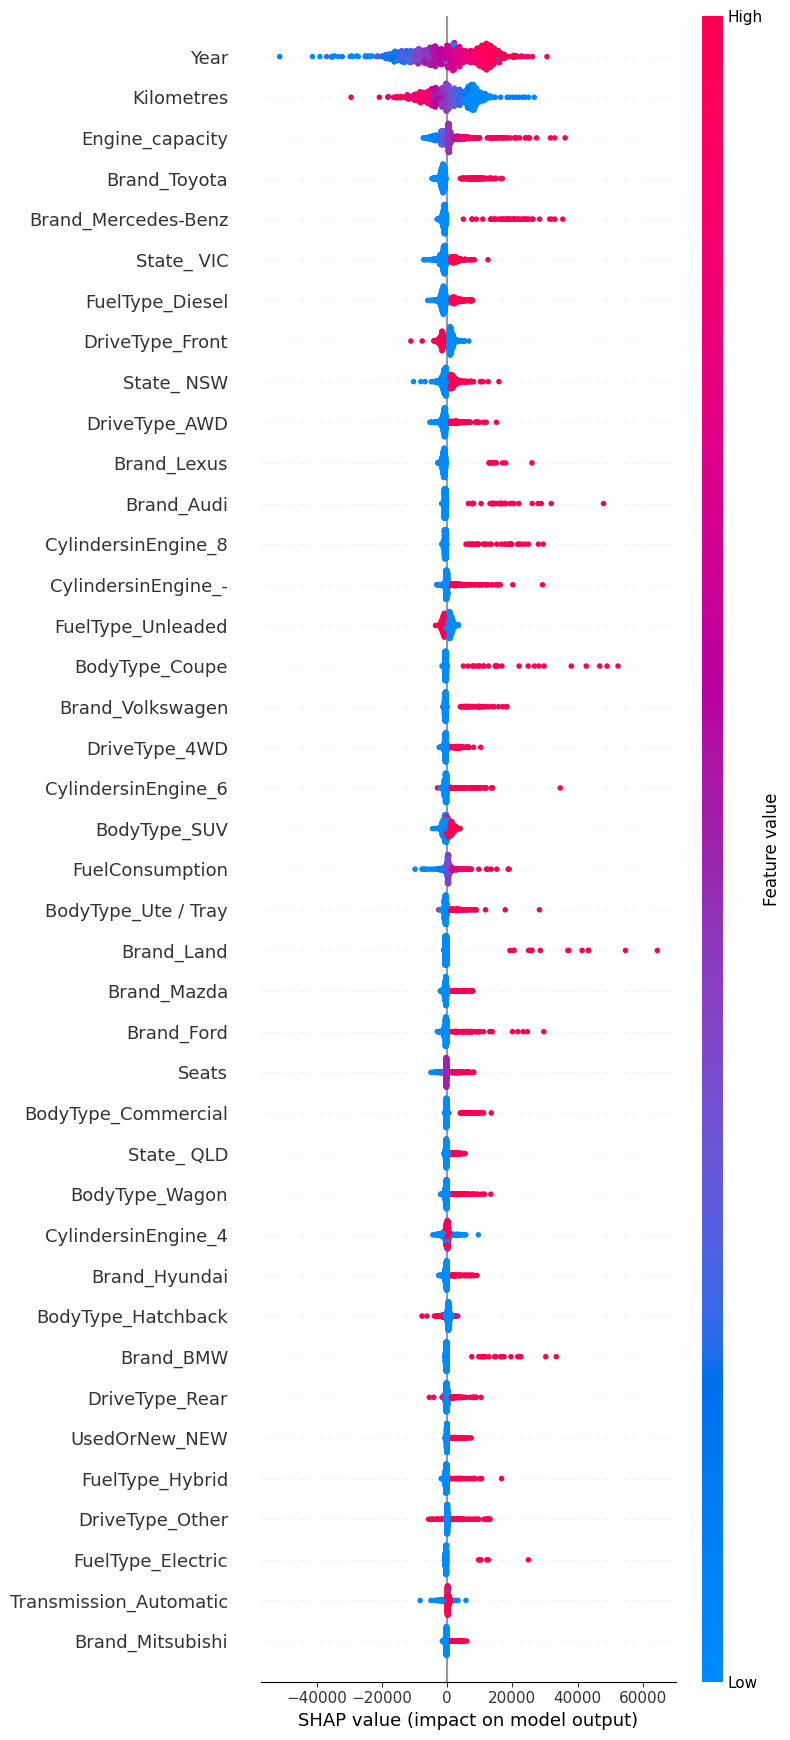

In [ ]:
from io import BytesIO
import numpy as np
from PIL import Image

def plot_pred_vs_actual(y_actual_test, y_pred_test):
    plt.figure(figsize=(6,6))
    plt.scatter(y_actual_test, y_pred_test, alpha=0.6)
    plt.plot([y_actual_test.min(), y_actual_test.max()], [y_actual_test.min(), y_actual_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs Actual")
    plt.grid(True)
    return plt.gcf()


def plot_residuals(y_actual_test, y_pred_test):
    residuals = y_pred_test - y_actual_test
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_test, residuals, alpha=0.6)
    plt.hlines(0, min(y_pred_test), max(y_pred_test), colors='red', linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    return plt.gcf()

# Convert tensors to NumPy
X_train_np = X_train_tensor.detach().cpu().numpy()
X_test_np = X_test_tensor.detach().cpu().numpy()

explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
shap_values = explainer(X_test_np)
shap.summary_plot(shap_values.values, X_test_np,feature_names=feature_names,max_display=40, show=False)
fig_shap = plt.gcf()
# Convert plot to image tensor
buf = BytesIO()
fig_shap.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
img = Image.open(buf).convert("RGB")
img = np.array(img).transpose(2, 0, 1)  # Convert to (C, H, W)

writer = SummaryWriter(f"runs_{timestamp}/Predictions")

fig1 = plot_pred_vs_actual(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Predicted vs Actual", fig1, global_step=0)

fig2 = plot_residuals(y_actual_test['Actual Price'].values, y_pred_test.tolist())
writer.add_figure("Residual Plot", fig2, global_step=0)

writer.add_image("SHAP Summary", img, global_step=0 )

writer.close()

In [ ]:
shap.initjs()

explainer = shap.Explainer(lambda x: model(torch.tensor(x, dtype=torch.float32)), X_train_np)
single_instance = X_test_np[[308]]  # shape: (1, n_features)
explanation = explainer(single_instance)
# Convert float32s to float64 or Python float
base_value=explanation.base_values[0].item()
shap_values = explanation.values[0].astype(float)
feature_values = single_instance[0].astype(float)

# Plot the force plot
shap.plots.force(base_value, shap_values, feature_values,feature_names=feature_names,)




# Model parameters summary

In [ ]:
print(model)
from torchinfo import summary
summary(model)

Regressor(
  (net): Sequential(
    (0): Linear(in_features=127, out_features=1216, bias=True)
    (1): BatchNorm1d(1216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1216, out_features=608, bias=True)
    (5): BatchNorm1d(608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=608, out_features=304, bias=True)
    (9): BatchNorm1d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=304, out_features=152, bias=True)
    (13): BatchNorm1d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=152, out_features=1, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
Regressor                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       155,648
│    └─BatchNorm1d: 2-2                  2,432
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       739,936
│    └─BatchNorm1d: 2-6                  1,216
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       185,136
│    └─BatchNorm1d: 2-10                 608
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      46,360
│    └─BatchNorm1d: 2-14                 304
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      153
Total params: 1,131,793
Trainable params: 1,131,793
Non-trainable params: 0